# Stocks analysis

## I - Libraries

In [1]:
import feedparser, pandas as pd, numpy as np
import time
from time import mktime
import os
import datetime
import collections
import matplotlib.pyplot as plt
import umap

 ## sklearn
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, scale
from sklearn.utils import shuffle

  ## API finance
from yahoo_finance import Share
from iexfinance import CorporateActions, get_historical_data , get_market_tops, get_stats_intraday, get_available_symbols, StockReader, Book
import pandas_datareader as pdr

  ## API earthquake
#from libcomcat.utils import get_phase_dataframe, get_summary_data_frame
from libcomcat.search import search,count,get_event_by_id


C:\Users\Lysis\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Lysis\Anaconda3\lib\site-packages\sklearn\grid_search.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, Sized
C:\Users\Lysis\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Lysis\Anaconda3

## II - Methods

In [2]:
def Corr_measure(data, x, y, windows=None):
    Size_ = data.shape[0]
    if windows == None: 
        if Size_ > 50:
            windows = range(50)
        else : 
            windows = range(int(Size_/2))
    else : 
        windows = range(windows)
    Correl_=[]
    for i in windows : 
        Correl_.append(np.corrcoef(data[x][0:Size_-i],data[y][i:Size_])[0,1])
    Max_Correl_ = np.argmax(np.abs(Correl_))
    print(" ========== ")
    print('Results of correlation between "{0}" and "{1}"'.format(x,y))
    print('Highest correlation ({0}) with a window : {1}'.format(round(Correl_[Max_Correl_],2),Max_Correl_))
    return [Correl_,Max_Correl_]

In [3]:
class Stocks_: 
    def __init__ (self, data, var_transform, rolling = [30,60,120,180], windows = 10, var_time_ = "Time", var_to_predict="Price", date="2018-09-23"):
        self.data = data
        self.var_transform = var_transform
        self.all_var = data.columns
        self.other_var = set(self.all_var)-set(self.var_transform)
        self.date = pd.to_datetime(date)
        self.date_max =  pd.to_datetime(self.data.Time.max())
            
        self.rolling_windows = rolling
        self.features= []
        self.features_saved= []
        self.Xtrain, self.Xtest = None, None
        self.Ytrain, self.Ytest = None, None
        self.windows = windows
        
        self.var_feature = []
        self.var_to_predict = var_to_predict
        self.var_time_ = var_time_
        
        self.Future_period = [i for i in [ pd.Timedelta(i,"D") + self.date_max for i in range(1,2*self.windows+1)] if i.weekday() not in [5,6]][:self.windows]
        self.counter = 0
        
    def Update_features(self):
        for i in self.rolling_windows:
            self.features.append(self.data[self.var_transform].rolling(i, min_periods=0).aggregate({'mean':np.mean,
                                                                                                    'std':np.std,
                                                                                                    'var' : np.var,
                                                                                                    'Gmax': lambda x : (x[-1]-max(x))/max(x),
                                                                                                    'Gmin': lambda x : (x[-1]-min(x))/min(x),
                                                                                                    'Delta_min_max' : lambda x : (np.argmax(x)-np.argmin(x)).total_seconds()/(3600*24),
                                                                                                    'Drawdown_min' : lambda x : (max(x)-min(x))/min(x),
                                                                                                    'Drawdown_max' : lambda x : (max(x)-min(x))/max(x)
                                                                                                   }))
        self.features =  pd.concat(self.features, axis=1) 
        self.features.columns = np.hstack([[ str(i)+"_"+j for j in ["_".join(k) for k in self.features.columns][0:(len(self.features.columns.levels[0])*len(self.features.columns.levels[1]))]] for i in  self.rolling_windows])
        self.features[[i +"_" for i in self.var_transform]] = self.data[self.var_transform]
        self.features  = self.features.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
        self.var_feature = self.features.columns
        self.features_saved = self.features.tail(self.windows)
        self.features = self.features.shift(self.windows)
        self.features[self.var_time_] = self.data[self.var_time_]
        self.features = self.features[self.windows:].reset_index(drop=True)
        self.counter += 1

    def Split(self):
        if self.counter == 0 :
            self.Update_features()
        else : 
            None
        if self.date >= self.date_max:
            self.Xtrain, self.Xtest = self.features[self.var_feature], self.features_saved[self.var_feature]
            self.Ytrain = self.data[self.windows:][self.var_to_predict].values
        else : 
            self.Xtrain, self.Xtest = self.features[self.features[self.var_time_] <= self.date][self.var_feature], self.features[self.features[self.var_time_] > self.date][self.var_feature]
            self.Ytrain, self.Ytest =  self.data[self.data[self.var_time_] <= self.date][self.var_to_predict][self.windows:].values, self.data[self.data[self.var_time_] > self.date][self.var_to_predict].values
            
    def Model(self, optimize = False):
        if self.counter == 0 :
            self.Split()
        else : 
            None
            
        if optimize : 
            param_grid_RF = {
            'n_estimators':[100,200,300,400],
            'max_depth': [2, 4, 6, 8, 10, 12],
            'max_features': [ 2, 4, 6, 8],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 3, 4]
            }
            
            param_grid_GBM = {
            'n_estimators':[100,200,300,400],
            'max_depth': [ 2, 4, 6, 8, 10, 12],
            'max_features': [ 2, 4, 6, 8],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 3, 4]
            }     
            
            RF_ = RandomForestRegressor()
            GBM_ = GradientBoostingRegressor()
                        
            grid_search_RF = GridSearchCV(estimator=RF_, param_grid=param_grid_RF, cv=3, n_jobs=-1)
            grid_search_GBM = GridSearchCV(estimator=GBM_, param_grid=param_grid_GBM, cv=3, n_jobs=-1)
            
            self.Model1 = grid_search_RF.fit(X=self.Xtrain, y=self.Ytrain)
            self.Model2 = grid_search_GBM.fit(X=self.Xtrain, y=self.Ytrain)
            self.Ypred1 = self.Model1.predict(self.Xtest)
            self.Ypred2 = self.Model2.predict(self.Xtest)
            
        else : 
            RFR_ = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
            GBM_ = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=2,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
            self.Model1 = RFR_.fit(self.Xtrain,self.Ytrain)
            self.Model2 = GBM_.fit(self.Xtrain,self.Ytrain)
            self.Ypred1 = self.Model1.predict(self.Xtest)
            self.Ypred2 = self.Model2.predict(self.Xtest)
        
    def Graph(self, optimize = False):
        if self.counter == 0 :
            self.Model(optimize)
        else : 
            None
        plt.figure(figsize=(10,10))
        if self.date >= self.date_max:
            plt.plot(self.Future_period,self.Ypred1, label="Model 1")
            plt.plot(self.Future_period,self.Ypred2, label="Model 2")
        else : 
            plt.plot(self.data[self.data[self.var_time_] > self.date][self.var_time_], self.Ypred1, label="Model 1")
            plt.plot(self.data[self.data[self.var_time_] > self.date][self.var_time_], self.Ypred2, label = "Model 2")
            plt.plot(self.data[self.data[self.var_time_] > self.date][self.var_time_], self.Ytest , label = "Current")
        plt.legend()
        plt.show()

## III - Data Sourcing

The goal is to retrieve stocks from 
     - WTTR - US
     - SES.TO - CANADA - http://www.secure-energy.ca/our-locations
     - FRAC -  US
     - SPN - US
     - SLCA - US
     - CLH - US

Initialization of the stocks to retrieve

In [4]:
Stocks = ["WTTR","SES.TO","FRAC","SPN","SLCA","CLH"]

Initialization of the US and Canada states

In [5]:
US_States = [i.lower() for  i in ["ca","Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri" ,"Montana" ,"Nebraska","Nevada" ,"New Hampshire" ,"New Jersey" ,"New Mexico" ,"New York","North Carolina" ,"North Dakota","Ohio" ,"Oklahoma" ,"Oregon","Pennsylvania" ,"Rhode Island","South Carolina","South Dakota" ,"Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]]
US_insular = [i.lower() for i in ["American Samoa", "Guam", "Northern Mariana Islands", "Puerto Rico", "U.S. Virgin Islands"]]
US_Federal_district = ["Washington, D.C.".lower()]
US_island = [i.lower() for i in["Baker Island" ,"Howland Island" ,"Jarvis Island" ,"Johnston Atoll" ,"Kingman Reef" ,"Midway Atoll" ,"Navassa Island" ,"Palmyra Atoll" ,"Wake Island"]]
US_ALL_ = US_States+ US_insular+ US_Federal_district +US_island
CANADA_ = [i.lower() for i in ["Alberta","British Columbia","Manitoba","New Brunswick","Newfoundland and Labrador","Nova Scotia","Ontario","Prince Edward Island","Quebec","Saskatchewan","Northwest Territories","Nunavut","Yukon"]]
US_CANADA = US_ALL_+CANADA_

### III.1 - Stocks sourcing

To retrieve stocks index we use the yahoo_finance API

In [6]:
Stock_index = pdr.get_data_yahoo(Stocks, start=datetime.datetime.now()-pd.Timedelta(6,"Y"), end=datetime.datetime.now())
Stock_index.columns=["_".join(i) for i in Stock_index.columns]
Stock_index["Time"] = Stock_index.index

### III.2 - Earthquake sourcing

In [15]:
df = pd.read_csv("C:\\Users\\Ksoeio\\Documents\\Work\\Dataset.csv", sep="\t")

In [14]:
eventlist = search(starttime=pd.to_datetime("2018-10-01"),
                       endtime=pd.to_datetime("2018-10-03"))

In [26]:
df = get_summary_data_frame(eventlist)

#### III.2.1 - Additional features

In [29]:
df['Date'] = df.time.apply(lambda x : pd.to_datetime(str(x)[0:10]))
df["Diff_time"] = df["time"].diff(1).apply(lambda x: x.seconds)
df["depth_corr"] = np.where(df.depth<0,0,df.depth)
df["Amplitude"]=np.exp((df.magnitude - 2.76*df.depth_corr+2.48)*np.log(10))  
df["AM"] = np.exp(-df.depth_corr+np.log(10))*df.magnitude
df["Locator_name_"]=df.location.apply(lambda x: x.lower()).apply(lambda x: x.split(',')[-1]).apply(lambda x : " ".join(x.split()))
df["Magnitude_interval"]=pd.cut(df["magnitude"], bins=[0,1.9,2.9,3.9,4.9,5.9,6.9,7.9,df["magnitude"].max()], include_lowest=True)
df["Countries"] = df["Locator_name_"].apply(lambda x : np.where( x in US_ALL_, "usa", np.where(x in CANADA_, "canada",x)))
df["US_CANADA"] = df["Countries"].apply(lambda x : np.where( x in ["usa","canada"], "us_canada", "other"))

The goal is to compute features based on highest amplitude of the earthquake

In [77]:
var_to_use=['depth_corr','magnitude','Amplitude','AM','Diff_time']
Basic_operator_ = {"mean","var","max","min"}
VAR_df= df[var_to_use+["Date"]].groupby("Date").agg(Basic_operator_)
VAR_df.columns = np.hstack([[j+"_"+i for i in Basic_operator_] for j in var_to_use])
VAR_df[["Count"]] = df[[var_to_use[0]]+["Date"]].groupby("Date").count()
VAR_df[[i+"_q95" for i in var_to_use]] = df[var_to_use+["Date"]].groupby("Date").agg({lambda x : x.quantile(0.95)})

In [79]:
VAR_df_countries = df[var_to_use+["Date","Countries"]].groupby(["Date","Countries"]).agg(Basic_operator_)
VAR_df_countries.columns = np.hstack([[j+"_"+i for i in Basic_operator_] for j in var_to_use])
VAR_df_countries[["Count"]] = df[[var_to_use[0]]+["Date","Countries"]].groupby(["Date","Countries"]).count()
VAR_df_countries[[i+"_q95" for i in var_to_use]] = df[var_to_use+["Date","Countries"]].groupby(["Date","Countries"]).agg({lambda x : x.quantile(0.95)})

In [81]:
VAR_df_countries_mm = df[var_to_use+["Date","Countries","Magnitude_interval"]].groupby(["Date","Countries","Magnitude_interval"]).agg(Basic_operator_)
VAR_df_countries_mm .columns = np.hstack([[j+"_"+i for i in Basic_operator_] for j in var_to_use])
VAR_df_countries_mm [["Count"]] = df[[var_to_use[0]]+["Date","Countries","Magnitude_interval"]].groupby(["Date","Countries","Magnitude_interval"]).count()
VAR_df_countries_mm [[i+"_q95" for i in var_to_use]] = df[var_to_use+["Date","Countries","Magnitude_interval"]].groupby(["Date","Countries","Magnitude_interval"]).agg({lambda x : x.quantile(0.95)})

In [82]:
VAR_df_countries_usac = df[var_to_use+["Date","US_CANADA"]].groupby(["Date","US_CANADA"]).agg(Basic_operator_)
VAR_df_countries_usac .columns = np.hstack([[j+"_"+i for i in Basic_operator_] for j in var_to_use])
VAR_df_countries_usac [["Count"]] = df[[var_to_use[0]]+["Date","US_CANADA"]].groupby(["Date","US_CANADA"]).count()
VAR_df_countries_usac [[i+"_q95" for i in var_to_use]] = df[var_to_use+["Date","US_CANADA"]].groupby(["Date","US_CANADA"]).agg({lambda x : x.quantile(0.95)})

In [83]:
VAR_df_countries_mm_usac = df[var_to_use+["Date","Countries","Magnitude_interval","US_CANADA"]].groupby(["Date","Countries","Magnitude_interval","US_CANADA"]).agg(Basic_operator_)
VAR_df_countries_mm_usac.columns = np.hstack([[j+"_"+i for i in Basic_operator_] for j in var_to_use])
VAR_df_countries_mm_usac[["Count"]] = df[[var_to_use[0]]+["Date","Countries","Magnitude_interval","US_CANADA"]].groupby(["Date","Countries","Magnitude_interval","US_CANADA"]).count()
VAR_df_countries_mm_usac[[i+"_q95" for i in var_to_use]] = df[var_to_use+["Date","Countries","Magnitude_interval","US_CANADA"]].groupby(["Date","Countries","Magnitude_interval","US_CANADA"]).agg({lambda x : x.quantile(0.95)})

In [84]:
Save_var = VAR_df.columns

In [85]:
VAR_df.columns = ["ALL_" + i for i in Save_var]
VAR_df_countries.columns = ["BY_STATES_" + i for i in Save_var]
VAR_df_countries_mm.columns = ["BY_STATES_MAG" + i for i in Save_var]
VAR_df_countries_usac.columns = ["BY_STATES_Grouped_" + i for i in Save_var]
VAR_df_countries_mm_usac.columns = ["BY_STATES_Grouped_MAG_" + i for i in Save_var]

### III.3 - Dataset of learning

In [90]:
Stock_index[VAR_df.columns] = VAR_df
Stock_index[VAR_df_countries.xs('mexico', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["mexico_"+i for i in VAR_df_countries.columns]))).columns] = VAR_df_countries.xs('mexico', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["mexico_"+i for i in VAR_df_countries.columns])))
Stock_index[VAR_df_countries.xs('usa', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["usa_"+i for i in VAR_df_countries.columns]))).columns] = VAR_df_countries.xs('usa', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["usa_"+i for i in VAR_df_countries.columns])))
Stock_index[VAR_df_countries.xs('canada', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["canada"+"_"+i for i in VAR_df_countries.columns]))).columns] = VAR_df_countries.xs('canada', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["canada"+"_"+i for i in VAR_df_countries.columns])))
Stock_index[VAR_df_countries_usac.xs('us_canada', level=1).rename(columns=dict(zip(VAR_df_countries_usac.columns,["us_canada"+"_"+i for i in VAR_df_countries_usac.columns]))).columns]=VAR_df_countries_usac.xs('us_canada', level=1).rename(columns=dict(zip(VAR_df_countries_usac.columns,["us_canada"+"_"+i for i in VAR_df_countries_usac.columns])))
Stock_index[VAR_df_countries_usac.xs('other', level=1).rename(columns=dict(zip(VAR_df_countries_usac.columns,["other"+"_"+i for i in VAR_df_countries_usac.columns]))).columns]=VAR_df_countries_usac.xs('other', level=1).rename(columns=dict(zip(VAR_df_countries_usac.columns,["other"+"_"+i for i in VAR_df_countries_usac.columns])))

In [151]:
VAR_EQ_ = list(set(Stock_index.columns) - set(list(np.hstack([[i for i in Stock_index.columns if j in i ]  for j in Stocks]))+["Time"]))
Base_Stocks_ =[]
j_=0
for i in Stocks:
    Base_Stocks_.append(Stock_index[[j for j in Stock_index.columns if i in j]].dropna(axis=0))
    Base_Stocks_[j_][VAR_EQ_] = Stock_index[VAR_EQ_]
    j_+=1

## IV - Data analysis

To pinpoint the relationship between earthquake and stock price we use pearson correlation measurement 

### IV.1- Correlation measurement

In [190]:
end_date = "2018-10-01"
begin_date = "2014-01-01"
x_1 = "us_canada_BY_STATES_Grouped_Count"
x_2 = "ALL_AM_mean"
x_3 = "ALL_Amplitude_mean"
Test = Stock_index

In [195]:
CLH_corr = Corr_measure(data=Test[(~Test.High_CLH.isnull())
                                  & (~Test[x_1].isnull()) #& (Test.index>"2012-01-01")& (Test.index<="2014-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_1, y="High_CLH")
FRAC_corr = Corr_measure(data=Test[(~Test.High_FRAC.isnull())
                                  & (~Test[x_1].isnull()) # & (Test.index>"2017-01-20")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_1, y="High_FRAC")
SLCA_corr = Corr_measure(data=Test[(~Test.High_SLCA.isnull())
                                  & (~Test[x_1].isnull())  #& (Test.index>"2012-01-01")& (Test.index<="2014-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_1, y="High_SLCA")
SPN_corr = Corr_measure(data=Test[(~Test.High_SPN.isnull())
                                  & (~Test[x_1].isnull())  #& (Test.index>"2012-01-01")& (Test.index<="2014-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_1, y="High_SPN")
WTTR_corr = Corr_measure(data=Test[(~Test.High_WTTR.isnull())
                                  & (~Test[x_1].isnull()) #& (Test.index>"2017-07-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_1, y="High_WTTR")
SES_corr = Corr_measure(data=Test[(~Test["High_SES.TO"].isnull())
                                  & (~Test[x_1].isnull()) #& (Test.index>"2017-07-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_1, y="High_SES.TO")

print("-----------------------------------------------------")
CLH_corr_AM = Corr_measure(data=Test[(~Test.High_CLH.isnull())
                                  & (~Test[x_2].isnull())
                                     #& (Test.index>"2012-01-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_2, y="High_CLH")
FRAC_corr_AM = Corr_measure(data=Test[(~Test.High_FRAC.isnull()) 
                                  & (~Test[x_2].isnull())#& (Test.index>"2017-01-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_2, y="High_FRAC")
SLCA_corr_AM = Corr_measure(data=Test[(~Test.High_SLCA.isnull())
                                  & (~Test[x_2].isnull()) #& (Test.index>"2012-01-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_2, y="High_SLCA")
SPN_corr_AM = Corr_measure(data=Test[(~Test.High_SPN.isnull())
                                  & (~Test[x_2].isnull())# & (Test.index>"2012-01-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_2, y="High_SPN")
WTTR_corr_AM = Corr_measure(data=Test[(~Test.High_WTTR.isnull()) 
                                  & (~Test[x_2].isnull())#& (Test.index>"2017-07-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_2, y="High_WTTR")

SES_corr_AM = Corr_measure(data=Test[(~Test["High_SES.TO"].isnull())
                                  & (~Test[x_2].isnull()) #& (Test.index>"2017-07-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_2, y="High_SES.TO")

print("------------------------------------------------------")
CLH_corr_Ampl = Corr_measure(data=Test[(~Test.High_CLH.isnull())
                                      & (~Test[x_3].isnull())
                                      & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_3, y="High_CLH", windows=100)
FRAC_corr_Ampl = Corr_measure(data=Test[(~Test.High_FRAC.isnull())
                                      & (~Test[x_3].isnull())
                                      & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_3, y="High_FRAC", windows=100)
SLCA_corr_Ampl = Corr_measure(data=Test[(~Test.High_SLCA.isnull())
                                      & (~Test[x_3].isnull())
                                      & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_3, y="High_SLCA", windows=100)
SPN_corr_Ampl = Corr_measure(data=Test[(~Test.High_SPN.isnull())
                                      & (~Test[x_3].isnull())
                                      & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_3, y="High_SPN", windows=100)
WTTR_corr_Ampl = Corr_measure(data=Test[(~Test.High_WTTR.isnull())
                                      & (~Test[x_3].isnull())
                                      & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_3, y="High_WTTR", windows=100)
SES_corr_Ampl = Corr_measure(data=Test[(~Test["High_SES.TO"].isnull())
                                  & (~Test[x_3].isnull()) #& (Test.index>"2017-07-01")& (Test.index<="2018-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>=begin_date)], x=x_3, y="High_SES.TO")


Results of correlation between "us_canada_BY_STATES_Grouped_Count" and "High_CLH"
Highest correlation (0.38) with a window : 31
Results of correlation between "us_canada_BY_STATES_Grouped_Count" and "High_FRAC"
Highest correlation (-0.49) with a window : 31
Results of correlation between "us_canada_BY_STATES_Grouped_Count" and "High_SLCA"
Highest correlation (-0.15) with a window : 31
Results of correlation between "us_canada_BY_STATES_Grouped_Count" and "High_SPN"
Highest correlation (-0.19) with a window : 17
Results of correlation between "us_canada_BY_STATES_Grouped_Count" and "High_WTTR"
Highest correlation (-0.53) with a window : 31
Results of correlation between "us_canada_BY_STATES_Grouped_Count" and "High_SES.TO"
Highest correlation (-0.11) with a window : 12
-----------------------------------------------------
Results of correlation between "ALL_AM_mean" and "High_CLH"
Highest correlation (0.45) with a window : 31
Results of correlation between "ALL_AM_mean" and "High_FRAC"


In [217]:
def approach3(givenNumber):  
    
    # Initialize a list
    primes = []
    for possiblePrime in range(2, givenNumber + 1):
        # Assume number is prime until shown it is not. 
        isPrime = True
        for num in range(2, int(possiblePrime ** 0.5) + 1):
            if possiblePrime % num == 0:
                isPrime = False
                break
        if isPrime:
            primes.append(possiblePrime)
    
    return(primes)

In [222]:
Prime_number = approach3(10000)

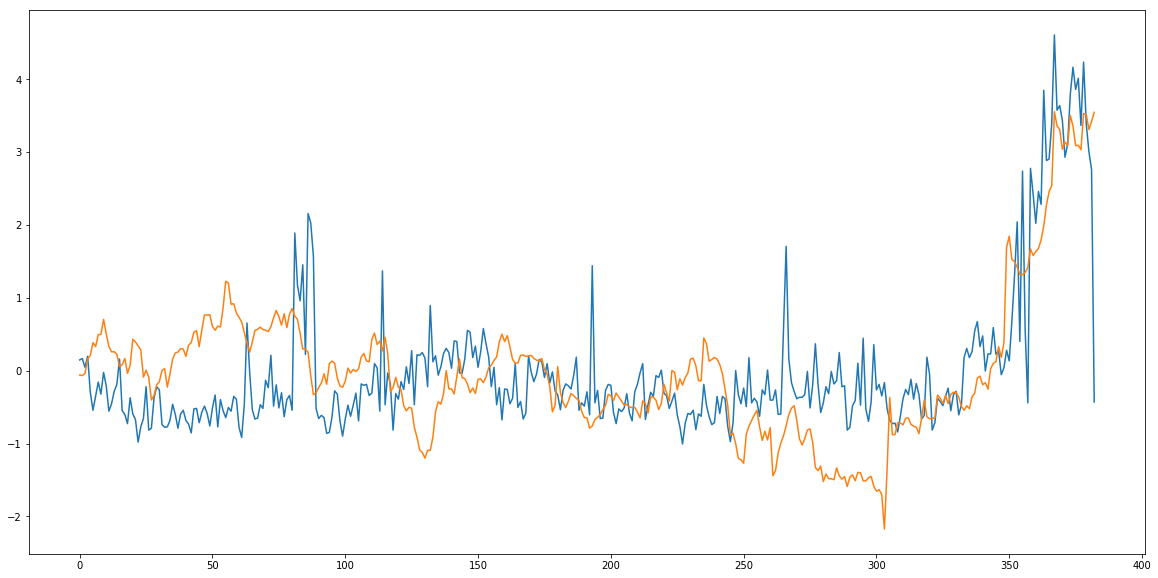

In [231]:
Val__ = Test[(~Test.High_CLH.isnull())
                                  & (~Test[x_1].isnull()) #& (Test.index>"2012-01-01")& (Test.index<="2014-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>="2017-01-01")]["Time"]
plt.figure(figsize=(20,10))
plt.plot(scale(Test[(~Test.High_CLH.isnull())
                                  & (~Test[x_1].isnull()) #& (Test.index>"2012-01-01")& (Test.index<="2014-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>="2017-01-01")][x_1][0:Val__.shape[0]-30]))
plt.plot(scale(Test[(~Test.High_CLH.isnull())
                                  & (~Test[x_1].isnull()) #& (Test.index>"2012-01-01")& (Test.index<="2014-01-01")
                                  & (Test.index<=end_date)
                                  & (Test.index>="2017-01-01")]["High_CLH"][30:]))
plt.show()

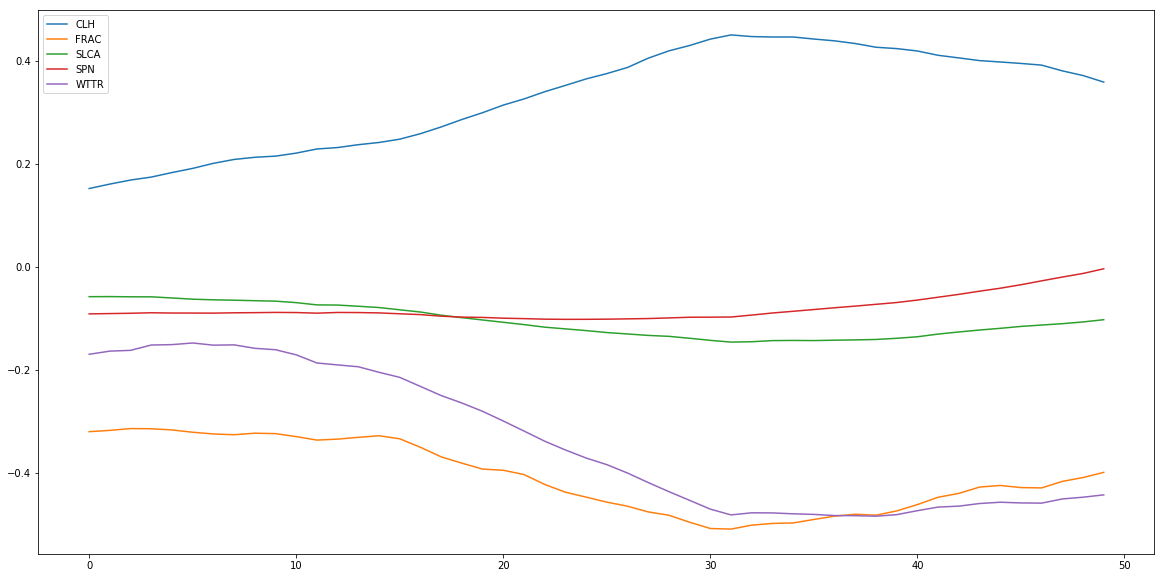

In [197]:
plt.figure(figsize=(20,10))
plt.plot(CLH_corr_AM[0], label="CLH")
plt.plot(FRAC_corr_AM[0], label="FRAC")
plt.plot(SLCA_corr_AM[0], label="SLCA")
plt.plot(SPN_corr_AM[0], label="SPN")
plt.plot(WTTR_corr_AM[0], label="WTTR")
plt.legend()
plt.show()

In [150]:
CLH_corr = Corr_measure(data=Test, x="Count", y="High_CLH", windows=100)
FRAC_corr = Corr_measure(data=Test, x="Count", y="High_FRAC", windows=100)
SLCA_corr = Corr_measure(data=Test, x="Count", y="High_SLCA", windows=100)
SPN_corr = Corr_measure(data=Test, x="Count", y="High_SPN", windows=100)
WTTR_corr = Corr_measure(data=Test, x="Count", y="High_WTTR", windows=100)

Results of correlation between "Count" and "High_CLH"
Highest correlation (0.88) with a window : 31
Results of correlation between "Count" and "High_FRAC"
Highest correlation (-0.74) with a window : 21
Results of correlation between "Count" and "High_SLCA"
Highest correlation (-0.8) with a window : 32
Results of correlation between "Count" and "High_SPN"
Highest correlation (-0.34) with a window : 24
Results of correlation between "Count" and "High_WTTR"
Highest correlation (-0.6) with a window : 32


In [157]:
CLH_corr_AM = Corr_measure(data=Test, x="Amplitude_mean", y="High_CLH", windows=100)
FRAC_corr_AM = Corr_measure(data=Test, x="Amplitude_mean", y="High_FRAC", windows=100)
SLCA_corr_AM = Corr_measure(data=Test, x="Amplitude_mean", y="High_SLCA", windows=100)
SPN_corr_AM = Corr_measure(data=Test, x="Amplitude_mean", y="High_SPN", windows=100)
WTTR_corr_AM = Corr_measure(data=Test, x="Amplitude_mean", y="High_WTTR", windows=100)

Results of correlation between "Amplitude_mean" and "High_CLH"
Highest correlation (0.86) with a window : 33
Results of correlation between "Amplitude_mean" and "High_FRAC"
Highest correlation (-0.78) with a window : 32
Results of correlation between "Amplitude_mean" and "High_SLCA"
Highest correlation (-0.78) with a window : 32
Results of correlation between "Amplitude_mean" and "High_SPN"
Highest correlation (0.3) with a window : 84
Results of correlation between "Amplitude_mean" and "High_WTTR"
Highest correlation (-0.56) with a window : 61


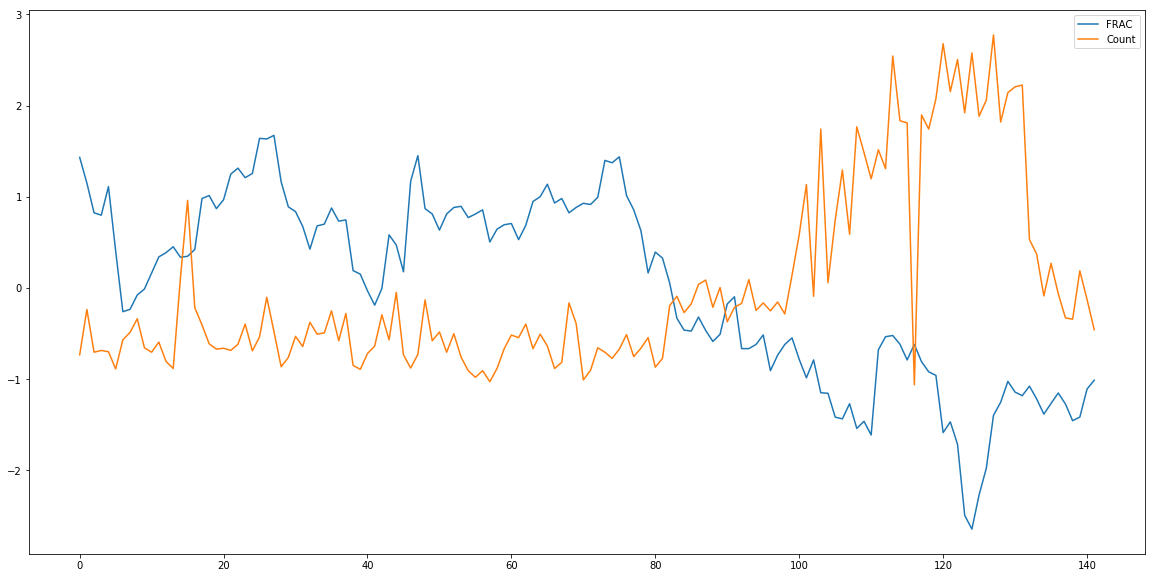

In [151]:
plt.figure(figsize=(20,10))
plt.plot(scale(Test.High_FRAC.reset_index(drop=True)[21:Test.shape[0]]),label="FRAC")
plt.plot(scale(Test.Count.reset_index(drop=True)[0:Test.shape[0]-21]), label="Count")
plt.legend()
plt.show()

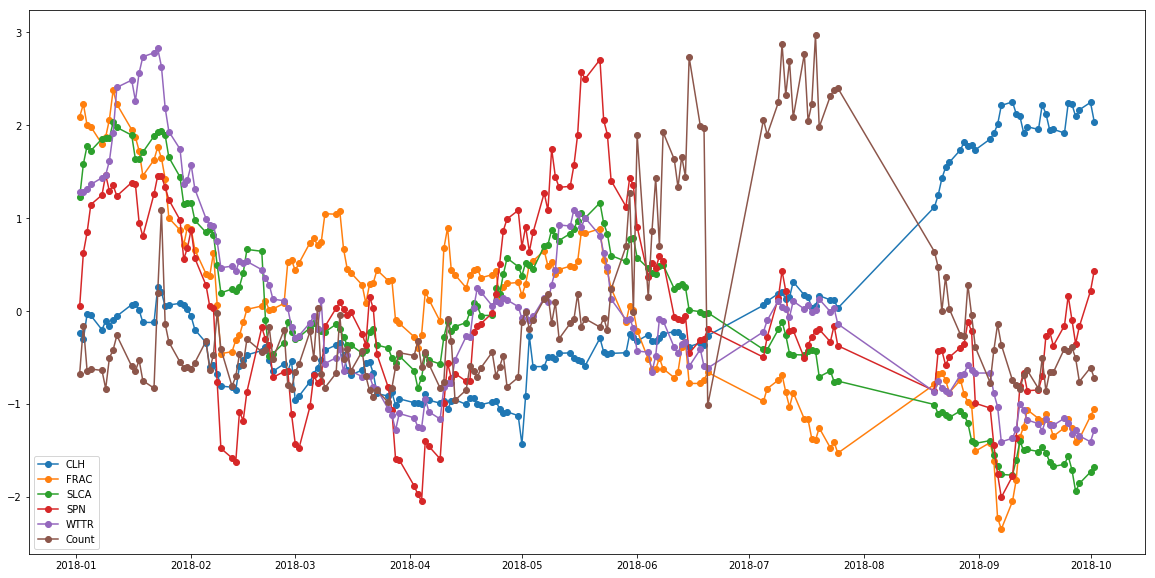

In [154]:
plt.figure(figsize=(20,10))
plt.plot_date(Test.index,(Test.High_CLH - np.mean(Test.High_CLH))/np.std(Test.High_CLH), linestyle='-', label="CLH")
plt.plot_date(Test.index,(Test.High_FRAC - np.mean(Test.High_FRAC))/np.std(Test.High_FRAC), linestyle='-', label="FRAC")
plt.plot_date(Test.index,(Test.High_SLCA - np.mean(Test.High_SLCA))/np.std(Test.High_SLCA), linestyle='-', label="SLCA")
plt.plot_date(Test.index,(Test.High_SPN - np.mean(Test.High_SPN))/np.std(Test.High_SPN), linestyle='-', label="SPN")
plt.plot_date(Test.index,(Test.High_WTTR - np.mean(Test.High_WTTR))/np.std(Test.High_WTTR), linestyle='-', label="WTTR")
plt.plot_date(Test.index,(Test.Count - np.mean(Test.Count))/np.std(Test.Count), linestyle='-', label="Count")
plt.legend()
plt.show()

In [76]:
np.corrcoef(Test.Count[0:Test.Count.shape[0]-25],Test.High_FRAC[25:Test.Count.shape[0]])

array([[ 1.        , -0.71053384],
       [-0.71053384,  1.        ]])

In [74]:
Test[(Test.index<="2018-06-20")&(Test.index>="2018-05-15")].shape

(25, 63)

## V - Modeling

In [131]:
win_ = 5
Company_Shares2=[]
k=0
for j in Stocks:
    Company_Shares2.append(Stock_index[[i for i in Stock_index.columns if j in i ]].dropna(axis=0))
    Company_Shares2[k].columns = ["high","low", "open", "close", "volume", "adjclose"]
    Company_Shares2[k]["Price"] = (Company_Shares2[k]["high"].values+Company_Shares2[k]["low"].values)/2.0
    Company_Shares2[k]["Time"] = Company_Shares2[k].index
    Company_Shares2[k] = Company_Shares2[k].dropna()
    Company_Shares2[k] = Company_Shares2[k][Company_Shares2[k].volume!=0]
    #Company_Shares2[k][VAR_df.columns] = VAR_df
    #Company_Shares2[k][VAR_df_countries.xs('mexico', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["mexico_"+i for i in VAR_df_countries.columns]))).columns] = VAR_df_countries.xs('mexico', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["mexico_"+i for i in VAR_df_countries.columns])))
    #Company_Shares2[k][VAR_df_countries.xs('usa', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["usa_"+i for i in VAR_df_countries.columns]))).columns] = VAR_df_countries.xs('usa', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["usa_"+i for i in VAR_df_countries.columns])))
    #Company_Shares2[k][VAR_df_countries.xs('canada', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["canada"+"_"+i for i in VAR_df_countries.columns]))).columns] = VAR_df_countries.xs('canada', level=1).rename(columns=dict(zip(VAR_df_countries.columns,["canada"+"_"+i for i in VAR_df_countries.columns])))
    #Company_Shares2[k][VAR_df_countries_usac.xs('us_canada', level=1).rename(columns=dict(zip(VAR_df_countries_usac.columns,["us_canada"+"_"+i for i in VAR_df_countries_usac.columns]))).columns] = VAR_df_countries_usac.xs('us_canada', level=1).rename(columns=dict(zip(VAR_df_countries_usac.columns,["us_canada"+"_"+i for i in VAR_df_countries_usac.columns])))
    #Company_Shares2[k][VAR_df_countries_usac.xs('other', level=1).rename(columns=dict(zip(VAR_df_countries_usac.columns,["other"+"_"+i for i in VAR_df_countries_usac.columns]))).columns] = VAR_df_countries_usac.xs('other', level=1).rename(columns=dict(zip(VAR_df_countries_usac.columns,["other"+"_"+i for i in VAR_df_countries_usac.columns])))
    Company_Shares2[k] = Company_Shares2[k].fillna(0)
    k+=1
Models_ = []
for i in range(len(Stocks)):
    Models_.append(Stocks_(Company_Shares2[i], list(set(Company_Shares2[0].columns)-set(["Time"])), date="2018-05-16", windows=win_))

WTTR


C:\Users\Lysis\Anaconda3\lib\site-packages\pandas\core\window.py:1561: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(Rolling, self).aggregate(arg, *args, **kwargs)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


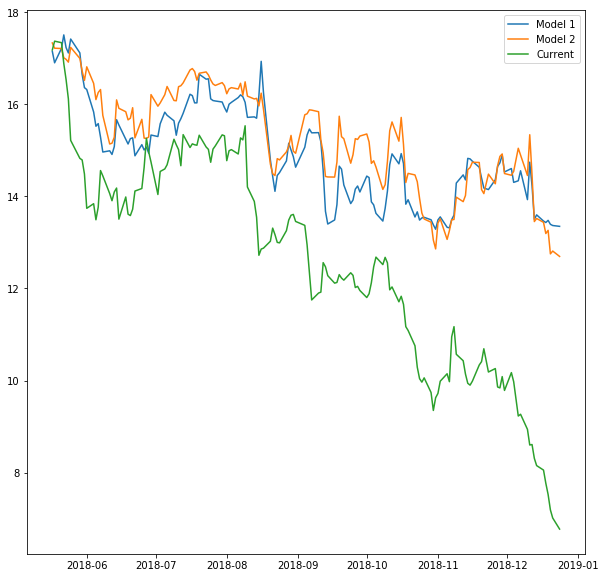

SES.TO


C:\Users\Lysis\Anaconda3\lib\site-packages\pandas\core\window.py:1561: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(Rolling, self).aggregate(arg, *args, **kwargs)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


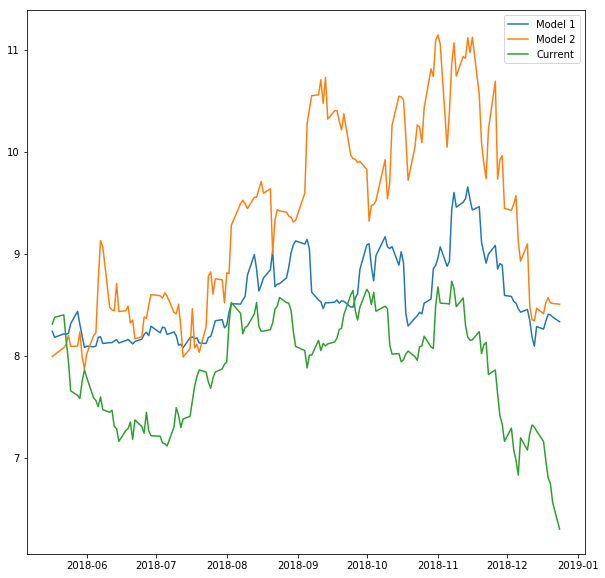

FRAC


C:\Users\Lysis\Anaconda3\lib\site-packages\pandas\core\window.py:1561: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(Rolling, self).aggregate(arg, *args, **kwargs)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


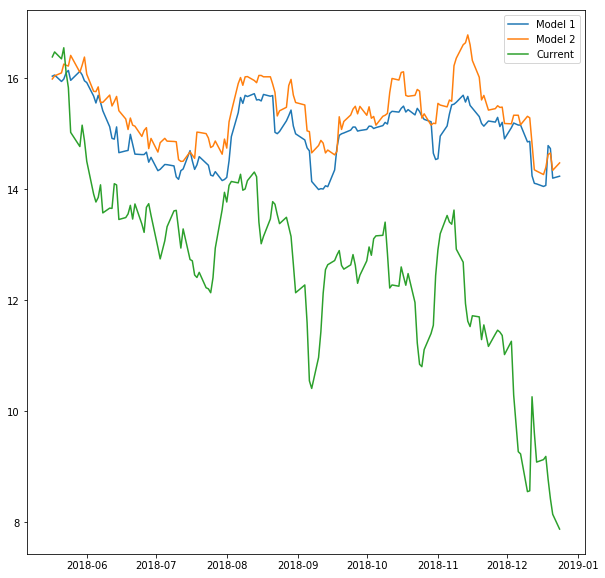

SPN


C:\Users\Lysis\Anaconda3\lib\site-packages\pandas\core\window.py:1561: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(Rolling, self).aggregate(arg, *args, **kwargs)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


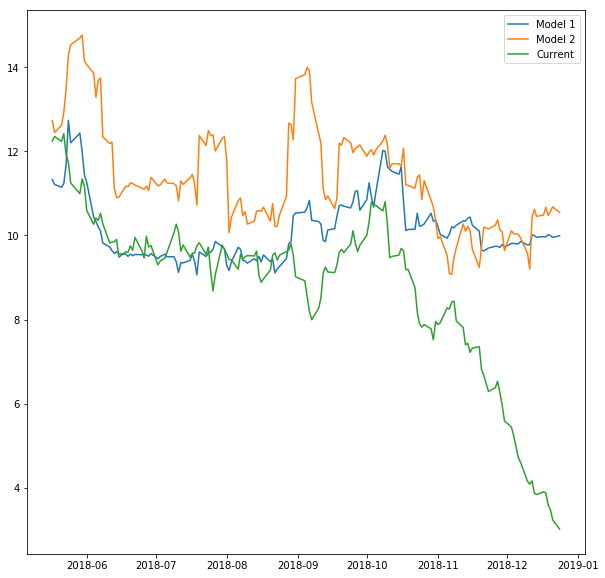

SLCA


C:\Users\Lysis\Anaconda3\lib\site-packages\pandas\core\window.py:1561: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(Rolling, self).aggregate(arg, *args, **kwargs)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


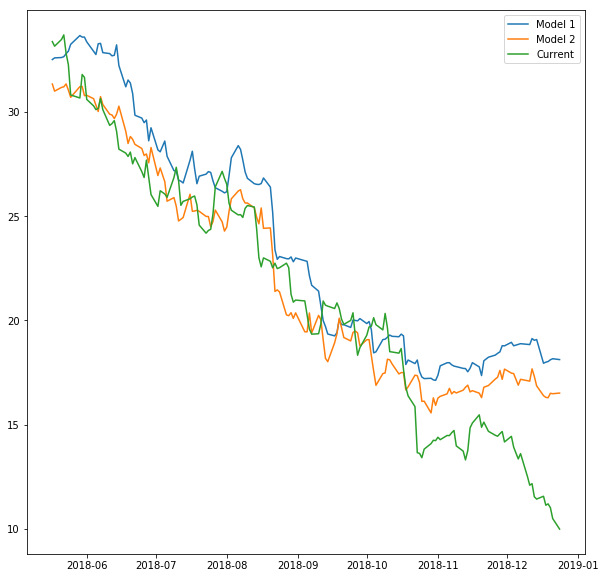

CLH


C:\Users\Lysis\Anaconda3\lib\site-packages\pandas\core\window.py:1561: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(Rolling, self).aggregate(arg, *args, **kwargs)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\Lysis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


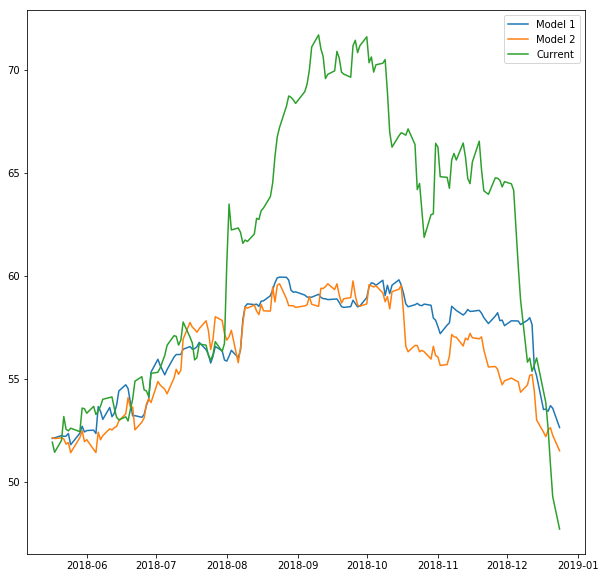

In [132]:
k=0
for i in Stocks:
    print(i)
    Models_[k].Graph()
    k +=1

In [46]:
embedding = umap.UMAP(n_neighbors=8,
                      min_dist=0.005,
                      metric='l2').fit_transform(test.Xtrain)


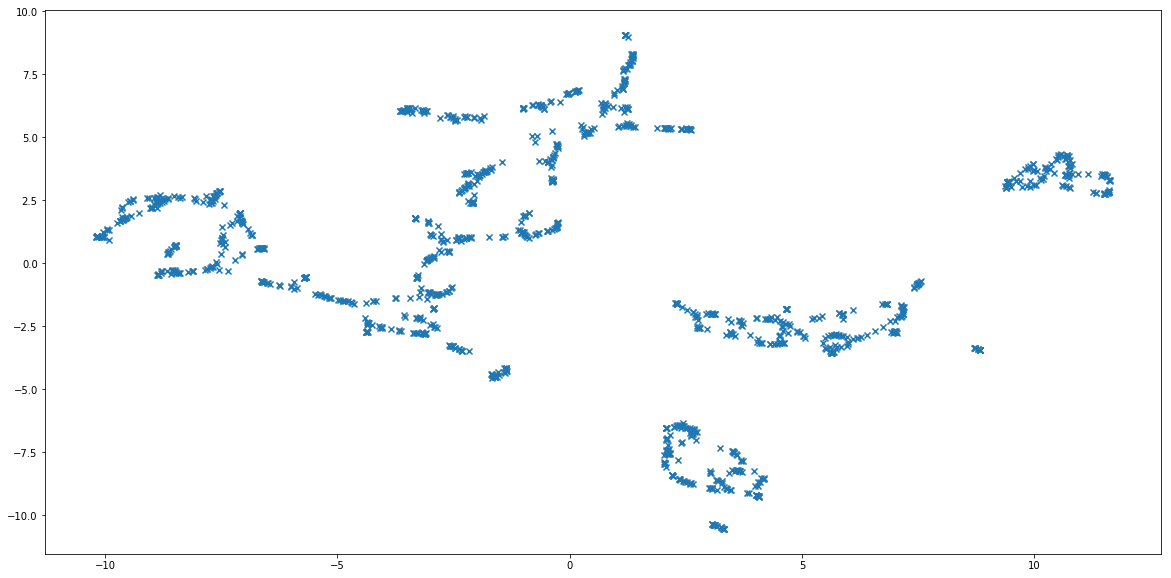

In [48]:
plt.figure(figsize=(20,10))
plt.scatter(embedding[:,0],embedding[:,1], marker="x")
plt.show()

In [54]:
embedding =pd.DataFrame(embedding, columns=["x","y"])

In [69]:
test.Xtrain[test.Xtrain.index.isin(list(embedding[(embedding.x>0)&(embedding.x<5)&(embedding.y<(-5))&(embedding.y>(-10))].index))].shape

(142, 150)

In [67]:
np.unique(list(embedding[(embedding.x>0)&(embedding.x<5)&(embedding.y<(-5))&(embedding.y>(-10))].index))

array([ 458,  459,  460,  461,  462,  463,  464,  465,  466,  467,  468,
        469,  470,  471,  472,  473,  474,  475,  476,  477,  478,  483,
        484,  485,  486,  487,  488,  489,  490,  491,  492,  493,  494,
        495,  496,  497,  499,  500,  501,  502,  503,  504,  505,  506,
        507,  508,  509,  510,  511,  512,  513,  514,  515,  516,  517,
        518,  522,  523,  524,  898,  899,  900,  901,  902,  903,  904,
        905,  906,  907,  926,  927,  928,  929,  930,  931,  932,  934,
        935,  936,  938,  939,  940,  956,  957,  962,  963,  964,  966,
        967,  968,  969,  970,  971,  972,  973,  974,  975,  976,  977,
        978,  979,  980,  981,  982,  983,  984,  985,  986,  987,  988,
        989,  990,  991,  992,  993,  994,  995,  996,  997,  998,  999,
       1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021], dtype=int64)